In [17]:
import os
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sensorium import data
from sensorium.utils import utils, tensorboard

utils.set_random_seed(1234)

GRAY = cm.get_cmap("gray")
BACKGROUND_COLOR = "#ffffff"

In [18]:
MOUSE_ID = 2

In [19]:
dataset, metadata = data.load_mice_data(
    mice_dir="../data/sensorium", mouse_ids=[MOUSE_ID]
)

Loading: 100%|██████████| 1/1 [00:09<00:00,  9.29s/it]


In [20]:
for i in dataset.keys():
    print(
        f'Mouse {i}\t\tnum. neurons: {dataset[i]["response"].shape[1]}\t\tnum. trials: {dataset[i]["image"].shape[0]}'
    )

Mouse 2		num. neurons: 8372		num. trials: 5994


In [21]:
# normalize array to range [0, 1]
normalize = lambda a: (a - np.min(a)) / (np.max(a) - np.min(a))
# standardize array to 0 mean and unit variance
standardize = lambda a: (a - np.mean(a)) / np.std(a)

Show image statistics

In [22]:
for k, v in metadata[MOUSE_ID]["stats"]["image"].items():
    print(f"{k}: {v}")

min: 0.0
max: 255.0
median: 107.0
mean: 111.28529357910156
std: 63.574520111083984


Show response statistics

In [23]:
for mouse_id in dataset.keys():
    print(f"\nMouse {mouse_id}")
    for tier in ["train", "validation", "test"]:
        idx = np.where(metadata[mouse_id]["tiers"] == tier)[0]
        response = dataset[mouse_id]["response"][idx]
        print(
            f"Tier: {tier}\n"
            f"min: {np.min(response):04f}, max: {np.max(response):04f}\n"
            f"mean: {np.mean(response):04f}, std: {np.std(response):04f}"
        )


Mouse 2
Tier: train
min: -0.000000, max: 506.363403
mean: 1.372593, std: 6.070605
Tier: validation
min: -0.000000, max: 440.794800
mean: 1.284734, std: 5.746231
Tier: test
min: -0.000000, max: 448.827576
mean: 1.283185, std: 5.755345


Plot mouse responses

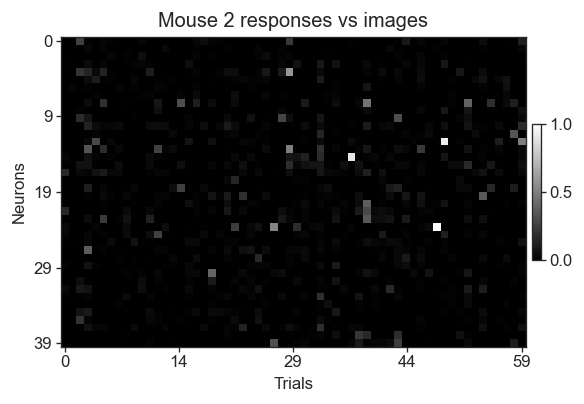

In [24]:
responses = normalize(dataset[MOUSE_ID]["response"])

figure, ax = plt.subplots(
    nrows=1,
    ncols=1,
    gridspec_kw={"wspace": 0.05, "hspace": 0.01},
    figsize=(5, 5),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)


N_TRIALS, N_NEURONS = 60, 40
ax.imshow(responses[:N_TRIALS, :N_NEURONS].T, cmap=GRAY)

x_ticks = np.linspace(0, N_TRIALS - 1, 5)
tensorboard.set_xticks(
    axis=ax, ticks_loc=x_ticks, ticks=x_ticks.astype(int), label="Trials"
)
y_ticks = np.linspace(0, N_NEURONS - 1, 5)
tensorboard.set_yticks(
    axis=ax, ticks_loc=y_ticks, ticks=y_ticks.astype(int), label="Neurons"
)

# add colorbar
width, height = 0.015, ax.get_position().y1 * 0.3
cbar_ax = figure.add_axes(
    rect=[
        ax.get_position().x1 + 0.01,
        ((ax.get_position().y1 - ax.get_position().y0) / 2 + ax.get_position().y0)
        - (height / 2),
        width,
        height,
    ]
)
figure.colorbar(cm.ScalarMappable(cmap=GRAY), cax=cbar_ax, shrink=0.1)
tensorboard.set_yticks(
    axis=cbar_ax,
    ticks_loc=np.linspace(0, 1, 3),
    ticks=np.linspace(0, 1, 3),
    label="",
)
ax.set_title(f"Mouse {MOUSE_ID} responses vs images")

tensorboard.save_figure(
    figure,
    filename=f"plots/mouse{MOUSE_ID}_responses_v_images.png",
    dpi=240,
    close=False,
)

plt.show()
plt.close(figure)

Plot image - response pairs from Mouse

image dimension: (1, 144, 256)
number of neurons: 8372


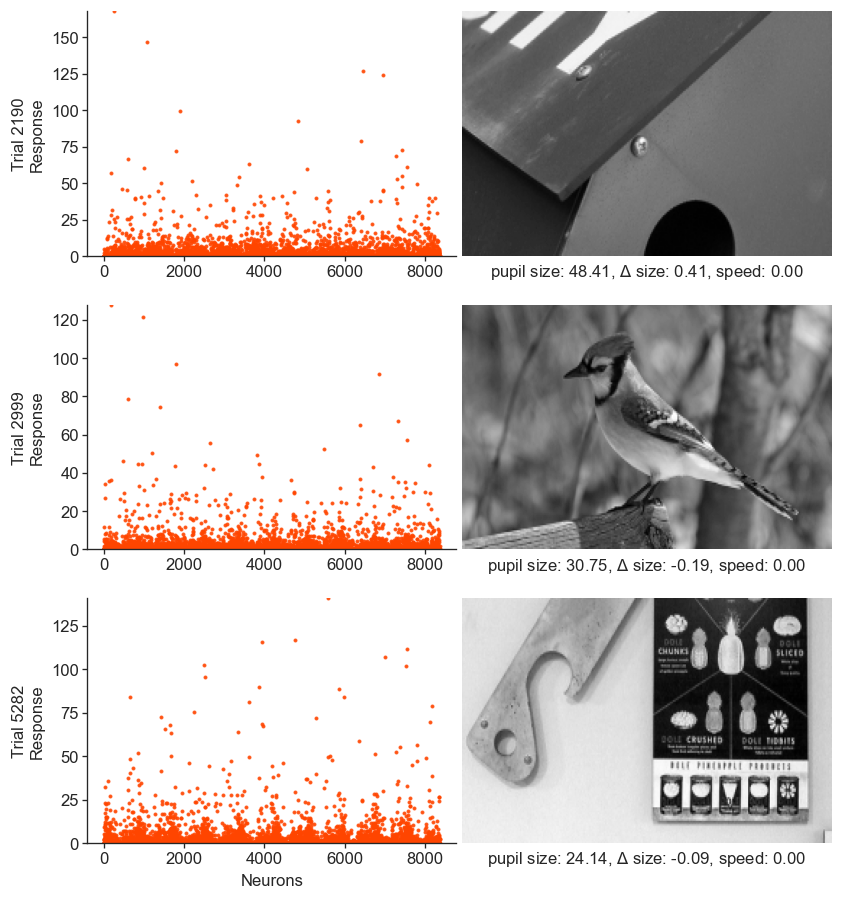

In [25]:
N_TRIALS = 3

images, responses, behaviors = (
    dataset[MOUSE_ID]["image"],
    dataset[MOUSE_ID]["response"],
    dataset[MOUSE_ID]["behavior"],
)
print(
    f"image dimension: {images.shape[1:]}\n" f"number of neurons: {responses.shape[1]}"
)

figure, axes = plt.subplots(
    nrows=N_TRIALS,
    ncols=2,
    gridspec_kw={"wspace": 0.015, "hspace": 0.2},
    figsize=(8, 3 * N_TRIALS),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)

trials = np.random.choice(images.shape[0], size=N_TRIALS, replace=False)
x_axis = np.arange(responses.shape[1])

for i, trial in enumerate(trials):
    # plot response
    axes[i, 0].scatter(x=x_axis, y=responses[trial], s=2, alpha=0.8, color="orangered")
    axes[i, 0].set_facecolor(BACKGROUND_COLOR)
    axes[i, 0].set_ylabel(f"Trial {trial:03d}\nResponse")
    if i == N_TRIALS - 1:
        axes[i, 0].set_xlabel("Neurons")
    tensorboard.remove_top_right_spines(axis=axes[i, 0])
    axes[i, 0].set_ylim(np.min(responses[trial]), np.max(responses[trial]))
    # plot natural image
    axes[i, 1].imshow(normalize(images[trial][0]), cmap=GRAY, aspect="auto")
    axes[i, 1].set_xlabel(
        rf"pupil size: {behaviors[trial][0]:.02f}, $\Delta$ size: {behaviors[trial][1]:.02f}, speed: {behaviors[trial][2]:.02f}"
    )
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    axes[i, 1].tick_params(axis="both", which="both", pad=0, length=0)
    tensorboard.remove_spines(axis=axes[i, 1])

tensorboard.save_figure(
    figure, filename="plots/mouse3_responses_v_images_2.png", dpi=240, close=False
)

plt.show()
plt.close(figure)

### Visualize cropping mode

In [26]:
import torch
from skimage.transform import rescale
from torchvision.transforms import functional as F

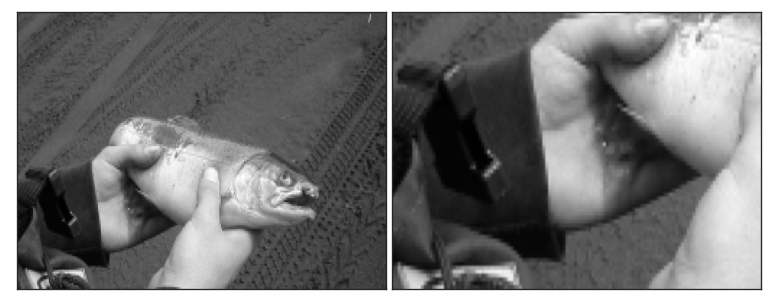

In [27]:
image = dataset[2]["image"][0]

figure, axes = plt.subplots(
    nrows=1,
    ncols=2,
    gridspec_kw={"wspace": 0.015, "hspace": 0.2},
    figsize=(8, 3),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)

axes[0].imshow(image[0], cmap=GRAY, aspect="auto")
axes[1].imshow(
    F.crop(torch.from_numpy(image), top=68, left=4, height=72, width=128)[0],
    cmap=GRAY,
    aspect="auto",
)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()

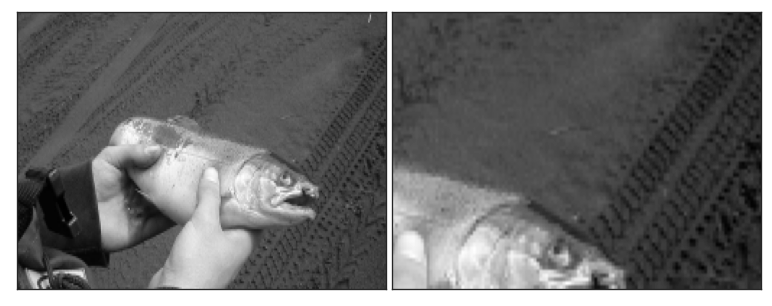

In [28]:
image = dataset[2]["image"][0]

figure, axes = plt.subplots(
    nrows=1,
    ncols=2,
    gridspec_kw={"wspace": 0.015, "hspace": 0.2},
    figsize=(8, 3),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)

axes[0].imshow(image[0], cmap=GRAY, aspect="auto")
axes[1].imshow(
    F.crop(torch.from_numpy(image), top=24, left=128, height=72, width=128)[0],
    cmap=GRAY,
    aspect="auto",
)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()

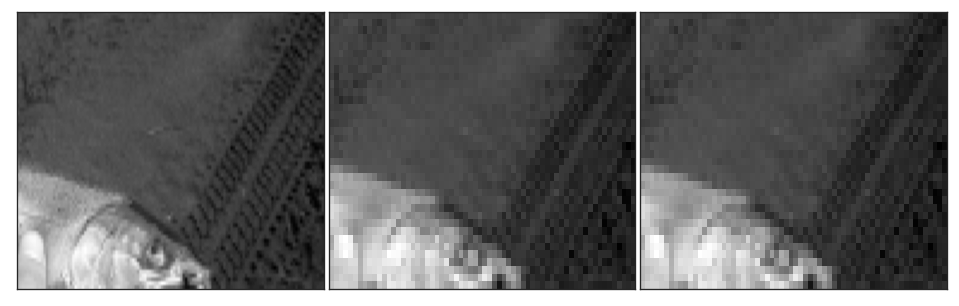

In [29]:
image = dataset[2]["image"][0]

figure, axes = plt.subplots(
    nrows=1,
    ncols=3,
    gridspec_kw={"wspace": 0.015, "hspace": 0.2},
    figsize=(10, 3),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)
crop_image = F.crop(torch.from_numpy(image), top=24, left=128, height=72, width=128)
axes[0].imshow(crop_image[0], cmap=GRAY, aspect="auto")
axes[1].imshow(
    F.resize(
        crop_image,
        size=[36, 64],
        antialias=False,
    )[0],
    cmap=GRAY,
    aspect="auto",
)
axes[2].imshow(
    rescale(
        crop_image.numpy(),
        scale=0.5,
        clip=True,
        preserve_range=True,
        anti_aliasing=False,
        channel_axis=0,
    )[0],
    cmap=GRAY,
    aspect="auto",
)

for i in range(len(axes)):
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

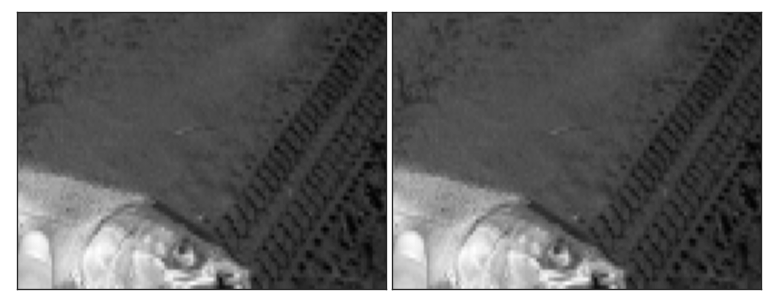

In [30]:
image = dataset[2]["image"][0]

figure, axes = plt.subplots(
    nrows=1,
    ncols=2,
    gridspec_kw={"wspace": 0.015, "hspace": 0.2},
    figsize=(8, 3),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)
axes[0].imshow(
    F.crop(torch.from_numpy(image), top=24, left=128, height=72, width=128)[0],
    cmap=GRAY,
    aspect="auto",
)
axes[1].imshow(
    image[0, 24 : 24 + 72, 128 : 128 + 128],
    cmap=GRAY,
    aspect="auto",
)

for i in range(len(axes)):
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

Plot Mouse 3 - 7 response distributions

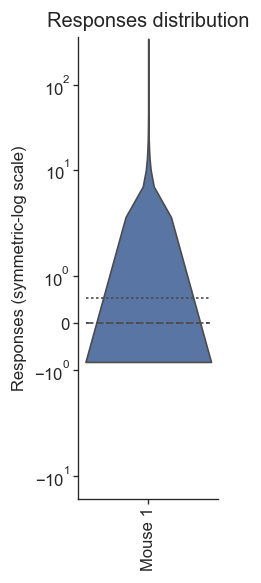

In [31]:
N_TRIALS = 100

figure, ax = plt.subplots(
    nrows=1,
    ncols=1,
    gridspec_kw={"wspace": 0.05, "hspace": 0.05},
    figsize=(1.5 * len(dataset), 5),
    dpi=120,
    facecolor=BACKGROUND_COLOR,
)

responses = [dataset[i]["response"][:N_TRIALS].flatten() for i in dataset.keys()]
sns.violinplot(
    data=responses,
    scale="area",
    width=0.9,
    inner="quartile",
    linewidth=1,
    ax=ax,
)
ax.set_facecolor(BACKGROUND_COLOR)
ax.set_yscale("symlog")
ax.set_xticklabels(
    [f"Mouse {i+1}" for i in range(len(dataset))], va="top", ha="center", rotation=90
)
ax.set_xlim(left=-0.5, right=len(responses) - 0.5)

tensorboard.remove_top_right_spines(axis=ax)
ax.set_ylabel("Responses (symmetric-log scale)")
ax.set_title("Responses distribution")

tensorboard.save_figure(
    figure, filename="plots/response_distribution.png", dpi=240, close=False
)

plt.show()
plt.close(figure)

Plot anatomical coordinates

In [34]:
dataset, metadata = data.load_mice_data(mice_dir="../data/sensorium")

Loading: 100%|██████████| 7/7 [01:06<00:00,  9.55s/it]


In [51]:
def plot_coordinates(coordinates, mouse_id: int):
    figure = plt.figure(figsize=(6, 6), dpi=120, facecolor=BACKGROUND_COLOR)
    ax = figure.add_subplot(1, 1, 1, projection="3d", facecolor=BACKGROUND_COLOR)
    ax.scatter3D(*coordinates.T, s=10, alpha=0.4, color="black")
    ax.set_xlabel("x coordinate (μm)")
    ax.set_ylabel("y coordinate (μm)")
    ax.set_zlabel("z coordinate (μm)")
    ax.set_title(f"Mouse {mouse_id} cell motor coordinates")
    figure.tight_layout()

    tensorboard.save_figure(
        figure,
        filename=f"plots/mouse{mouse_id}_cell_coordinates.png",
        dpi=240,
        close=False,
    )

    plt.show()
    plt.close(figure)

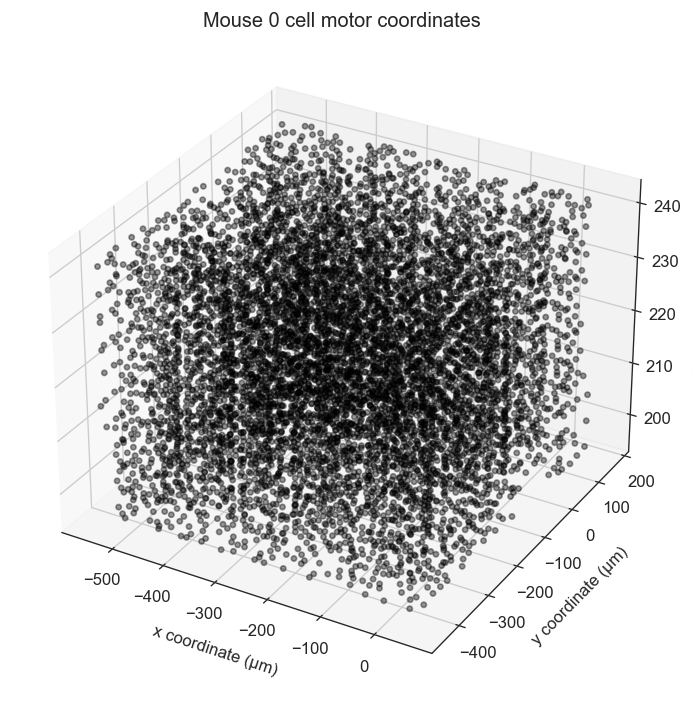

In [52]:
plot_coordinates(metadata[0]["coordinates"], mouse_id=0)

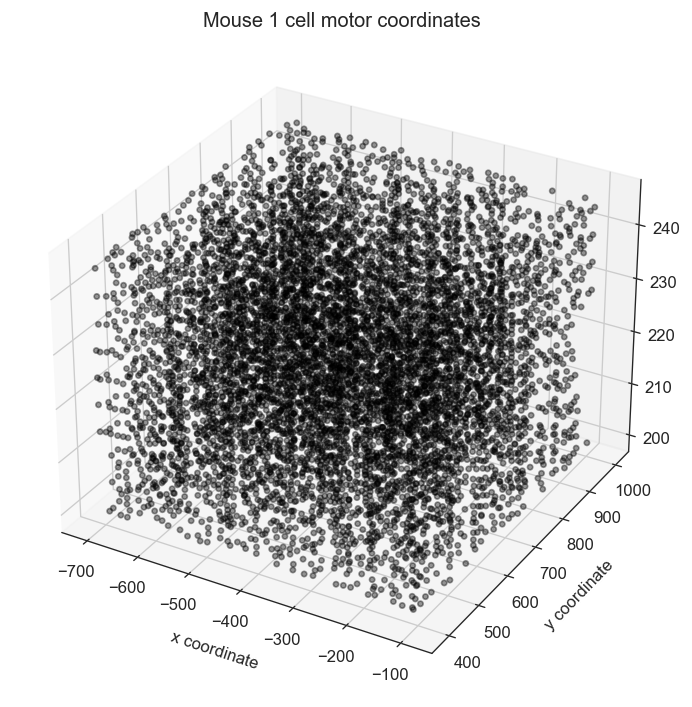

In [45]:
plot_coordinates(metadata[1]["coordinates"], mouse_id=1)

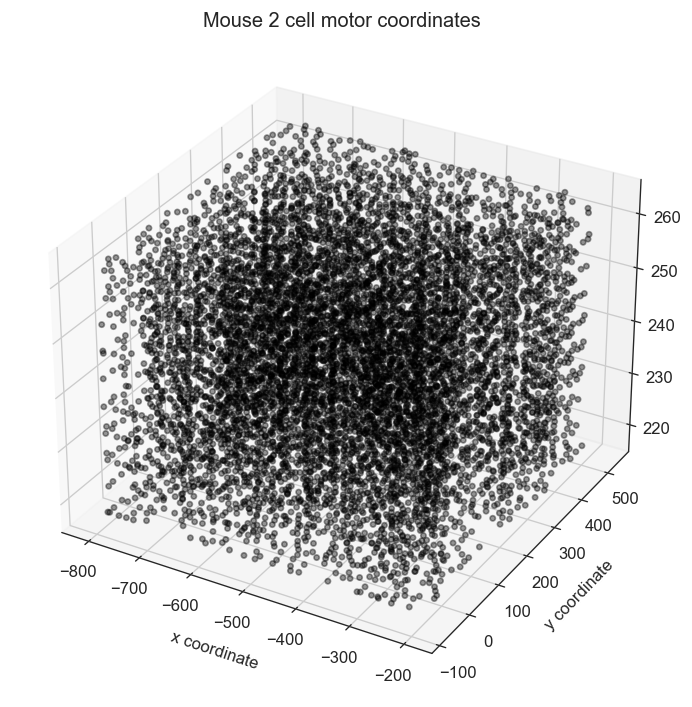

In [46]:
plot_coordinates(metadata[2]["coordinates"], mouse_id=2)

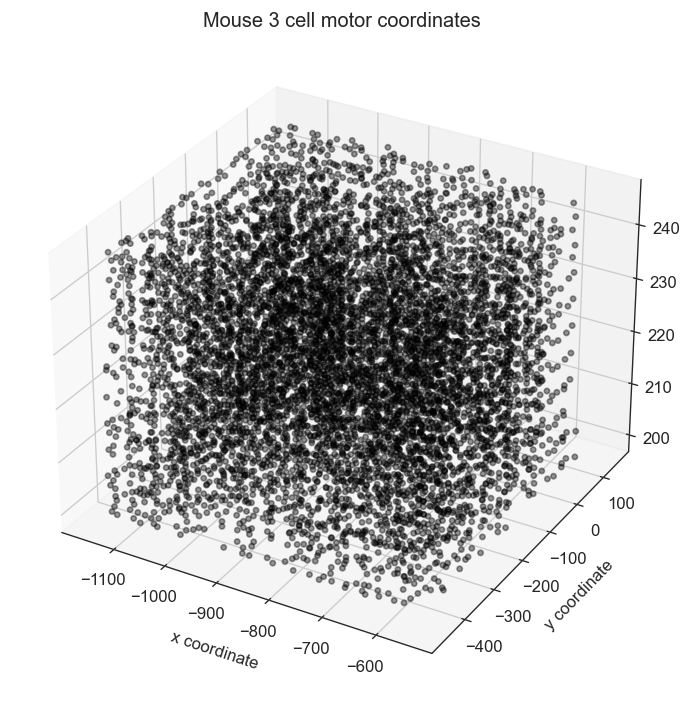

In [47]:
plot_coordinates(metadata[3]["coordinates"], mouse_id=3)

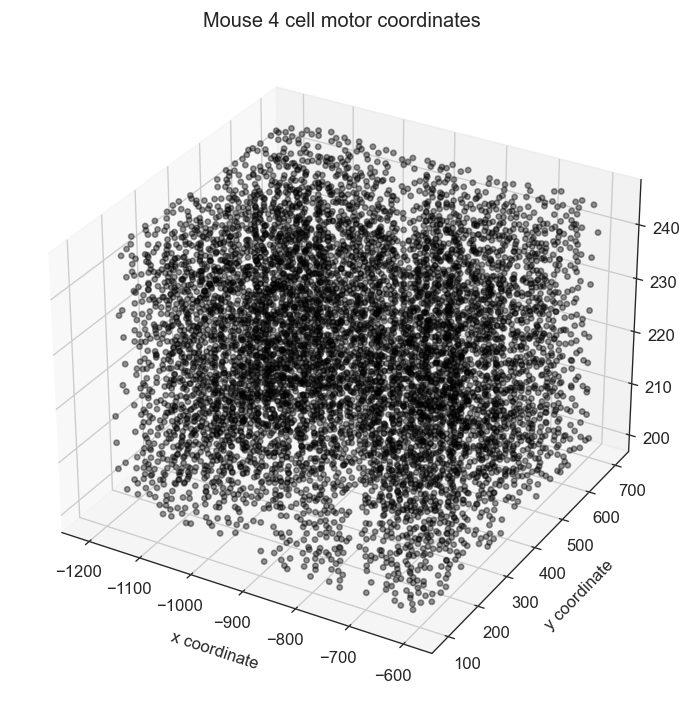

In [48]:
plot_coordinates(metadata[4]["coordinates"], mouse_id=4)

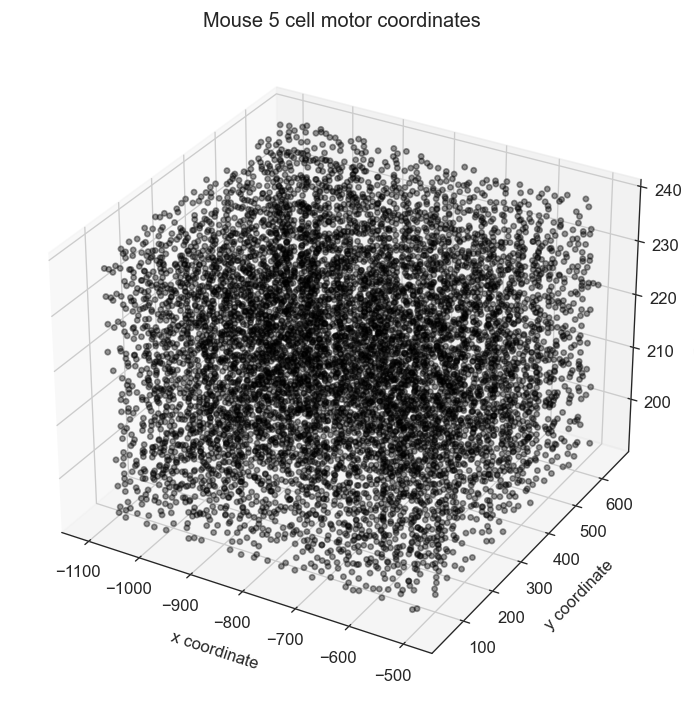

In [49]:
plot_coordinates(metadata[5]["coordinates"], mouse_id=5)

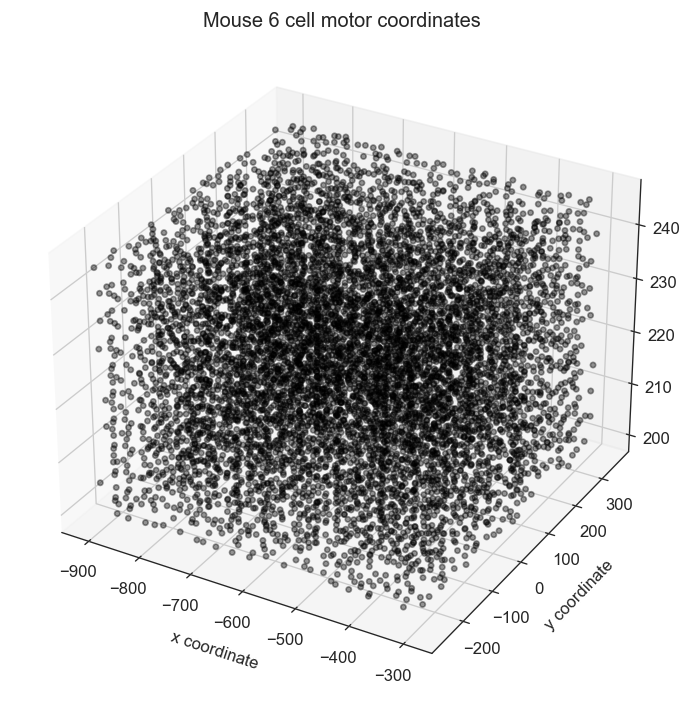

In [50]:
plot_coordinates(metadata[6]["coordinates"], mouse_id=6)